# Background: Optimisers in Deep Learning
A key component of deep learning is the iterative weight update equation, often called an optimiser. The optimiser is responsible for updating the weights of the network in order to minimise the loss function, and the choice of optimiser can have a significant impact on the performance of the model. In this coursework, you will be implement from scratch some popular optimisers and compare their performance in a simple neural network classifying the MNIST dataset.

**Task**: to implement the following optimisers for MNIST classification tasks: **AdaGrad** (Adaptive gradient), **RMSProp** (Root mean square propagation), and **Adam** (Adaptive moments).

**Data**: MNIST dataset, which contains 60,000 training images and 10,000 testing images of handwritten digits.


### Optimiser recap
We first have a quick recap of the basic ideas in each of the optimisers.  

* Stochastic gradient descent (one data point at a time):
    $$ \begin{align*}
        w^{(\tau)} &= w^{(\tau-1)} + \Delta w^{(\tau-1)}, \\
        \Delta w^{(\tau-1)} &= - \eta \nabla E_{n}(w^{\tau-1})
    \end{align*} $$

* SGD with momentum:
    $$\begin{align*}
        w^{(\tau)} &= w^{(\tau-1)} + \Delta w^{(\tau-1)}, \\
        \Delta w^{(\tau-1)} &= - \eta \left[\nabla E_{n}(w^{\tau-1}) + \mu \Delta w^{(\tau-2)}\right]
    \end{align*} $$
    where $\mu$ ('mu') is called the *momentum parameter*.

* AdaGrad (Adaptive gradient): to reduce each learning rate by using the accumulated sum of squared gradients
$$    \begin{align*}
        r_i^{(\tau)} &= r_i^{(\tau-1)} + \left(\frac{\partial E(w)}{\partial w_i}\right)^2, \\
        w_i^{(\tau)} &= w_i^{(\tau-1)} - \frac{\eta}{\sqrt{r_i^{(\tau)}} + \epsilon}\frac{\partial E(w)}{\partial w_i}
    \end{align*} $$

* RMSProp (Root mean square propagation): moving average of the squared gradient
    $$ \begin{align*}
        r_i^{(\tau)} &= \beta r_i^{(\tau-1)} + (1-\beta) \left(\frac{\partial E(w)}{\partial w_i}\right)^2, \\
        w_i^{(\tau)} &= w_i^{(\tau-1)} - \frac{\eta}{\sqrt{r_i^{(\tau)}} + \epsilon}\frac{\partial E(w)}{\partial w_i}
    \end{align*}$$
    where $\beta$ ('beta') is called the *decay rate* of the moving average.

* Adam (Adaptive moments): moving average for both the gradient and the squared gradient
    $$ \begin{align*}
        s_i^{(\tau)} &= \beta_1 s_i^{(\tau-1)} + (1-\beta_1) \frac{\partial E(w)}{\partial w_i}, \\
        r_i^{(\tau)} &= \beta_2 r_i^{(\tau-1)} + (1-\beta_2) \left(\frac{\partial E(w)}{\partial w_i}\right)^2 \\
        \hat{s_i}^{(\tau)} &= \frac{s_i^{(\tau)}}{1-\beta_1^{\tau}}, \\
        \hat{r_i}^{(\tau)} &= \frac{r_i^{(\tau)}}{1-\beta_2^{\tau}}, \\
        w_i^{(\tau)} &= w_i^{(\tau-1)} - \frac{\eta}{\sqrt{\hat{r_i}^{(\tau)}} + \epsilon}\hat{s_i}^{(\tau)}
    \end{align*}$$
    where $\beta_1, \beta_2$ are the *decay rates* of the moving averages, and with $\beta_1^{\tau}, \beta_2^{\tau}$ we denote $\beta_1, \beta_2$ to the power $\tau$.

In all cases, $\eta$ is the learning rate, and $\epsilon$ is a small number to avoid division by zero improve numerical stability.

### Hyperparameter settings

In your implementations, please use the following hyperparameter setups: $\epsilon=1e-6$, $\mu=0.9$, $\eta=0.01$, $\beta=0.99$, $\beta_1=0.9$, $\beta_2=0.99$. (DO NOT CHANGE ANY OF THEM)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch.optim as optim (this is NOT allowed; you can't use torch optimizers)
from torchvision import datasets, transforms

batch_size = 64
test_batch_size = 1000
lr = 0.01
seed = 10

device = torch.device("cpu") #torch.device("cuda") or torch.device("cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}

and the following convnet:

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) #1个输入通道，32个输出通道，卷积核大小为3x3，步长为1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25) #丢弃率为0.25，用于减少过拟合
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128) #全连接层fc1，输入特征数为9216，输出特征数为128
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x) #第一个卷积层处理输入数据x
        x = F.relu(x) #应用ReLU激活函数，增加非线性
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

We also provide the test function to report the test accuracy.

In [3]:
# for test accuracy report
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Dataset

MNIST is a well-known dataset of images of handwritten digits. A copy of the MNIST dataset is included in PyTorch. We will download it, then load it into memory using the `torchvision` module.

In [4]:
# The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard
# deviation of the MNIST dataset. This is equivalent to scaling all pixel values between [0, 1].
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
dataset1 = datasets.MNIST('./data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('./data', train=False, transform=transform)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████████████████████████████████| 9.91M/9.91M [00:01<00:00, 7.86MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|███████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 314kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 2.73MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 2.61MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



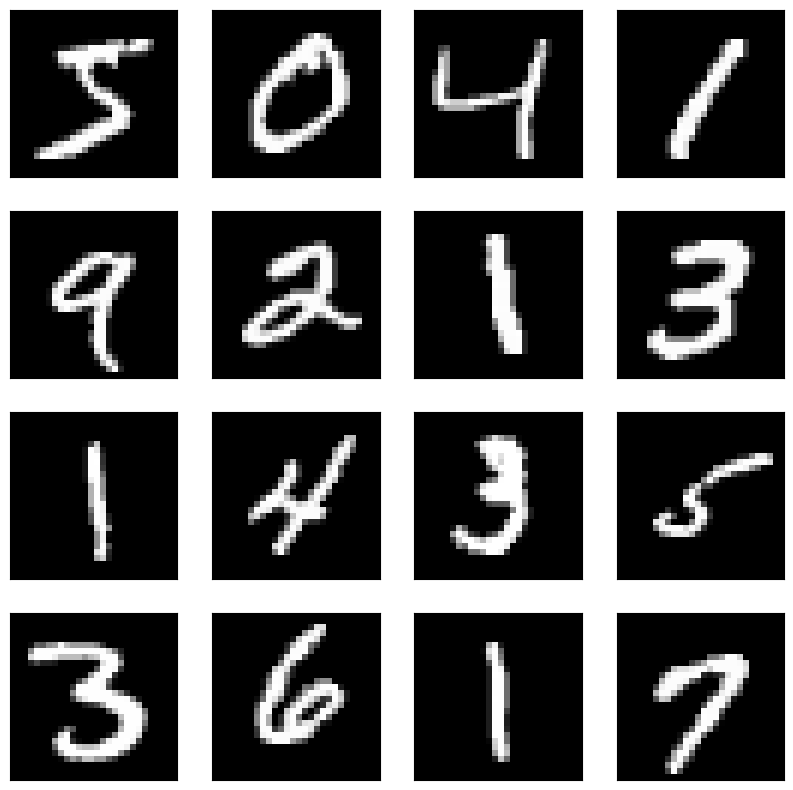

In [5]:
import matplotlib.pyplot as plt
# Visualize the first 16 elements of the training set
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(dataset1.data[i], cmap='gray')

# Implementations (7 marks)
In PyTorch, optimisers are created by passing the model parameters and hyperparameters to the optimiser class. The optimiser is then used to update the model parameters after each forward pass. Following this convension, we will write our optimisers as *classes*, an example structure for which is given below. Feel free to add whatever parameters or class functions that you see fit.

Implement the optimisers **AdaGrad** (Adaptive gradient), **RMSProp** (Root mean square propagation), and **Adam** (Adaptive moments) below.

In [6]:
#adagrad_optimizer
class adagrad_optimizer:

     # Initialize the model, learning rate, and a small value for numerical stability 初始化
    def __init__(self, model, lr=0.01, epsilon=1e-6):
        self.model = model
        self.lr = lr
        self.epsilon = epsilon
        self.accumulated_grad_squares = [torch.zeros_like(p) for p in model.parameters()]

     # Update each parameter using the Adagrad algorithm 更新参数
    def step(self):
        for i, param in enumerate(self.model.parameters()):
            if param.grad is not None:
                self.accumulated_grad_squares[i] += param.grad ** 2
                adjustment = self.lr / (self.accumulated_grad_squares[i].sqrt() + self.epsilon)
                param.data -= adjustment * param.grad

    # Zero the gradients for the next iteration 为下一次迭代将梯度归零
    def zero_grad(self):
        for param in self.model.parameters():
            if param.grad is not None:
                param.grad.zero_()

#####################################################################################################

#rmsprop_optimizer
class rmsprop_optimizer:

    # Initialize the model, learning rate, and a small value for numerical stability 初始化
    def __init__(self, model, lr=0.01, rho=0.99, epsilon=1e-6):
        self.model = model
        self.lr = lr
        self.rho = rho
        self.epsilon = epsilon
        self.accumulated_grad_squares = [torch.zeros_like(p) for p in model.parameters()]

    # Update each parameter using the Adagrad algorithm 更新参数
    def step(self):
        for i, param in enumerate(self.model.parameters()):
            if param.grad is not None:
                self.accumulated_grad_squares[i] = self.rho * self.accumulated_grad_squares[i] + (1 - self.rho) * (param.grad ** 2)
                adjustment = self.lr / (self.accumulated_grad_squares[i].sqrt() + self.epsilon)
                param.data -= adjustment * param.grad

    # Zero the gradients for the next iteration 为下一次迭代将梯度归零
    def zero_grad(self):
        for param in self.model.parameters():
            if param.grad is not None:
                param.grad.zero_()

#####################################################################################################
# adam_optimizer
class adam_optimizer:

    # Initialize the model, learning rate, and a small value for numerical stability 初始化
    def __init__(self, model, lr=0.01, beta1=0.9, beta2=0.99, epsilon=1e-6):
        self.model = model
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [torch.zeros_like(p) for p in model.parameters()]  # First moment estimation 一阶矩估计
        self.v = [torch.zeros_like(p) for p in model.parameters()]  # Second moment estimation 二阶矩估计
        self.t = 0

    # Update each parameter using the Adagrad algorithm 更新参数
    def step(self):
        self.t += 1
        for i, param in enumerate(self.model.parameters()):
            if param.grad is not None:
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * param.grad
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (param.grad ** 2)
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                param.data -= self.lr * m_hat / (v_hat.sqrt() + self.epsilon)

    # Zero the gradients for the next iteration 为下一次迭代将梯度归零
    def zero_grad(self):
        for param in self.model.parameters():
            if param.grad is not None:
                param.grad.zero_()



In [7]:
def train(log_interval, model, device, train_loader, test_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # 清除梯度
        output = model(data)
        loss = F.nll_loss(output, target)

        ########################################
        # TODO
        # put your optimizer implementations here. Feel free to move your codes around
        # HINTS: You can use loss.backward() to compute gradients and then access the
        # gradients in your functions via [p.grad.data for p in model.parameters()].
        # Or you can compute the gradients by calling the torch.autograd.grad function.

        loss.backward()  # Computed gradients via backpropagation反向传播计算梯度

        optimizer.step()  # Updated parameter更新参数
        ########################################

        if batch_idx % log_interval == 0:
            print(f'Train: [{batch_idx * len(data)}/{len(train_loader.dataset)}({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

            test(model, device, test_loader)

# Model training and submission (3 marks)

Use the following training settings for your model training. You may have to run this code multiple times, or create a loop, to train the model with different optimisers.

In [8]:
# Training settings
cuda_kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

# Initialize the model and optimizer list
log_interval = 10

# Create the optimizer dictionary
optimizers = {
    "adagrad": adagrad_optimizer(Net().to(device), lr=0.01, epsilon=1e-6),
    "rmsprop": rmsprop_optimizer(Net().to(device), lr=0.01, rho=0.99, epsilon=1e-6),
    "adam": adam_optimizer(Net().to(device), lr=0.01, beta1=0.9, beta2=0.99, epsilon=1e-6)
}

# Train each optimizer separately and save the model
for optimizer_name, optimizer in optimizers.items():
    print(f"\nTraining with {optimizer_name} optimizer:")

    # Initializing the model
    model = optimizer.model

    # training model
    train(log_interval, model, device, train_loader, test_loader, optimizer)

    # save
    torch.save(model.state_dict(), f"mnist_cnn_{optimizer_name}.pt")
    print(f"Model trained with {optimizer_name} saved as 'mnist_cnn_{optimizer_name}.pt'")


Training with adagrad optimizer:
Train: [0/60000(0%)]	Loss: 2.304011

Test set: Average loss: 14.6498, Accuracy: 1479/10000 (15%)

Train: [640/60000(1%)]	Loss: 1.544461

Test set: Average loss: 1.2862, Accuracy: 6157/10000 (62%)

Train: [1280/60000(2%)]	Loss: 0.302985

Test set: Average loss: 0.4050, Accuracy: 8808/10000 (88%)

Train: [1920/60000(3%)]	Loss: 0.272422

Test set: Average loss: 0.2878, Accuracy: 9211/10000 (92%)

Train: [2560/60000(4%)]	Loss: 0.455804

Test set: Average loss: 0.2712, Accuracy: 9211/10000 (92%)

Train: [3200/60000(5%)]	Loss: 0.057196

Test set: Average loss: 0.2263, Accuracy: 9349/10000 (93%)

Train: [3840/60000(6%)]	Loss: 0.175752

Test set: Average loss: 0.2061, Accuracy: 9363/10000 (94%)

Train: [4480/60000(7%)]	Loss: 0.145704

Test set: Average loss: 0.2034, Accuracy: 9434/10000 (94%)

Train: [5120/60000(9%)]	Loss: 0.203875

Test set: Average loss: 0.1763, Accuracy: 9465/10000 (95%)

Train: [5760/60000(10%)]	Loss: 0.283379

Test set: Average loss: 0.15